In [15]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import nltk
# nltk.download()

import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import wordcloud, STOPWORDS
import os
import itertools

from nltk import sent_tokenize, word_tokenize, FreqDist
from nltk.data import load
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect

from deep_translator import GoogleTranslator

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore")

<h1> Staging the Data </h1>

<h2> Read the data files and concatenate </h2>

In [16]:
df1 = pd.read_csv('7282_1.csv')
df2 = pd.read_csv('Datafiniti_Hotel_Reviews_Jun19.csv')
df3 = pd.read_csv('Datafiniti_Hotel_Reviews.csv')

In [17]:
print('Number of observations in df1: ', len(df1))
print('Number of observations in df2: ', len(df2))
print('Number of observations in df3: ', len(df3))
print('Total number of observations in the raw dataset should then be: ', len(df1)+len(df2)+len(df3))

Number of observations in df1:  35912
Number of observations in df2:  10000
Number of observations in df3:  10000
Total number of observations in the raw dataset should then be:  55912


<h4> Examine the raw, concatinated dataset </h4>

In [18]:
df4 = pd.concat([df1,df2,df3], ignore_index=True)
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55912 entries, 0 to 55911
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   address               55912 non-null  object 
 1   categories            55912 non-null  object 
 2   city                  55912 non-null  object 
 3   country               55912 non-null  object 
 4   latitude              55826 non-null  float64
 5   longitude             55826 non-null  float64
 6   name                  55912 non-null  object 
 7   postalCode            55857 non-null  object 
 8   province              55912 non-null  object 
 9   reviews.date          55653 non-null  object 
 10  reviews.dateAdded     35912 non-null  object 
 11  reviews.doRecommend   0 non-null      float64
 12  reviews.id            0 non-null      float64
 13  reviews.rating        55050 non-null  float64
 14  reviews.text          55889 non-null  object 
 15  reviews.title      

Several data columns are such that only 20,000 observations are non-null values, which is the total size of df2 and df3 together. This is indicative that these columns are not present in df1. More, many of these columns are extraneous as the information is already captured in the columns that they have in common with df1.

Concatenating each dataframe such that only common columns are present in the resulting dataset. In other words, we will concatenate using an innner join.

In [19]:
df = pd.concat([df1, df2, df3],join='inner',ignore_index=True)

In [20]:
max(df.index)

55911

<h3> We can print out the info of the dataframe, and some sample rows to check </h3>

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55912 entries, 0 to 55911
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   address               55912 non-null  object 
 1   categories            55912 non-null  object 
 2   city                  55912 non-null  object 
 3   country               55912 non-null  object 
 4   latitude              55826 non-null  float64
 5   longitude             55826 non-null  float64
 6   name                  55912 non-null  object 
 7   postalCode            55857 non-null  object 
 8   province              55912 non-null  object 
 9   reviews.date          55653 non-null  object 
 10  reviews.rating        55050 non-null  float64
 11  reviews.text          55889 non-null  object 
 12  reviews.title         54288 non-null  object 
 13  reviews.userCity      30427 non-null  object 
 14  reviews.username      55869 non-null  object 
 15  reviews.userProvinc

In [22]:
# df.rename(columns = {
#     col : f"{col} ({dtype})"
#     for col, dtype in df.dtypes.to_dict().items()
# }).sample(5, random_state = 0)

<h2> Initial Data Cleaning </h2>

<li> Drop the columns with no observations 
<li> Rename the reviews columns
<li> Drop the rows where review ratings or review texts are not available
<li> Replace the empty titles with an empty string instead of NaN

In [23]:
df.dropna(axis = 'columns', how = 'all', inplace = True)

Check out the reviews columns in more detail

In [24]:
df.loc[:, df.columns.str.startswith("review")].head()

,reviews.date,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,2013-09-22T00:00:00Z,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,2015-04-03T00:00:00Z,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,2014-05-13T00:00:00Z,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,2013-10-27T00:00:00Z,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,2015-03-05T00:00:00Z,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [25]:
old_names = ['reviews.date', 'reviews.rating', 'reviews.title', 'reviews.text', 'reviews.userCity', 
             'reviews.username', 'reviews.userProvince'] 
new_names = ['date', 'rating', 'title', 'text', 'userCity', 'username', 'userProvince']
df.rename(columns = dict(zip(old_names, new_names)), inplace = True)
df.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,date,rating,text,title,userCity,username,userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [26]:
df.dropna(subset = ['rating', 'text'], inplace = True)
df

,address,categories,city,country,latitude,longitude,name,postalCode,province,date,rating,text,title,userCity,username,userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55907,215 S Pacific St,"Hotel,Hotels,Lodging,Motels",Rockaway Beach,US,45.611260,-123.945560,Silver Sands Oceanfront Motel,97136-9596,OR,2016-03-13T00:00:00Z,3.0,It is hard for me to review an oceanfront hote...,Picture Window Ocean View!,Wildwood,LASH0211,GA
55908,669 Route 6a,"Hotel,Hotels",East Sandwich,US,41.729390,-70.399250,Sandy Neck Motel,02537-1472,MA,2015-12-11T00:00:00Z,4.0,"I live close by, and needed to stay somewhere ...","Clean, comfortable and quiet",East Sandwich,Gennaker,MA
55909,702 W Appleway Ave,"Hotel,Hotel, Motel, and Building,Hotels,Lodgin...",Coeur d'Alene,US,47.699930,-116.796900,Shilo Inn Suites - Coeur d'Alene,83814-9338,ID,2017-11-17T00:00:00.000Z,4.0,Rolled in 11:30 laid out heads down woke up to...,Passing through,Montana,Amber406,UnitedStates
55910,2295 N Highland Ave,"Hotel,Hotels Motels,Budget Hotels,Hotels & Motels",Jackson,US,35.666390,-88.830120,Scottish Inn,38305-4922,TN,2016-06-09T00:00:00Z,1.0,Absolutely terrible..I was told I was being gi...,Terrible,woodbury,donWoodbury,NaN


In [27]:
df['title'].fillna('', inplace = True)

<h2> More data cleaning (done by Erica) </h2>

In [28]:
# # Not using this data in this notebook since all the steps to attain a similar dataset are completed in this notebook.
# # Just reviewing the cleaned data here.
# df_cleaned = pd.read_csv('cleaned_review_df.csv')
# df_cleaned.drop(columns = ['Unnamed: 0', 'rating_cat', 'month', 'rating_category'], inplace = True)
# df_cleaned

<h1> Preliminary Exploratory Data Analysis </h1>

<h2> Ratings distribution </h2>

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [30]:
df['rating'].unique()

array([ 4.  ,  5.  ,  3.  ,  1.  ,  2.  ,  0.  ,  4.1 ,  4.9 ,  4.8 ,
        3.4 ,  2.4 ,  3.1 ,  3.2 ,  3.3 ,  9.6 , 10.  ,  8.3 ,  8.8 ,
        9.2 ,  7.5 ,  7.9 ,  7.1 ,  3.8 ,  5.8 ,  6.7 ,  6.3 ,  4.2 ,
        4.5 ,  3.9 ,  1.3 ,  4.3 ,  4.7 ,  2.8 ,  4.4 ,  1.5 ,  4.6 ,
        3.7 ,  5.4 ,  2.5 ,  6.  ,  2.9 ,  7.  ,  9.5 ,  3.55,  4.15,
        3.95,  3.35,  3.75,  2.1 ,  1.65,  3.15,  2.7 ,  1.45,  2.75,
        2.3 ,  3.5 ,  4.25,  1.25,  1.9 ,  3.45,  3.25,  4.75])

In [31]:
df['rating'].describe()

count    55027.000000
mean         3.879251
std          1.335006
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         10.000000
Name: rating, dtype: float64

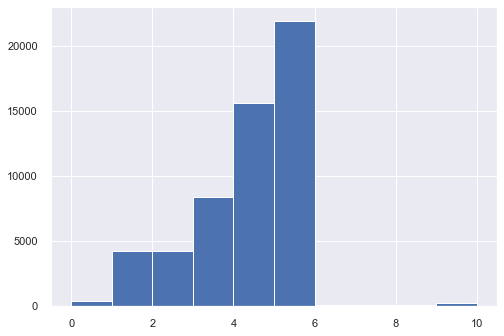

In [32]:
sns.set()
df['rating'].hist()
plt.savefig('./Figures/raw_ratings_hist.jpg')

As we can see, not all ratings are an integers, and ratings range from 0 to 10, even though the majority fall within the range from 1-5.

In [33]:
df['rating'].describe()

count    55027.000000
mean         3.879251
std          1.335006
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         10.000000
Name: rating, dtype: float64

In [34]:
print("Number of ratings greater than 5:", df[df['rating'] > 5].shape[0])
print("Percent of ratings greater than 5:", df[df['rating'] > 5].shape[0] / df.shape[0])

Number of ratings greater than 5: 357
Percent of ratings greater than 5: 0.006487724208116016


Only 0.6% of all hotel ratings are greater than 5.

In [35]:
# df = df[df['rating'] <= 5]

We also note that the minimum rating in the dataset is 0. The histogram plotted above indicates that the number of reviews with a rating of 0 is small relative to all other ratings. To assure that this the case, we compute the following:

In [36]:
print("Number of ratings equal to 0:", df[df['rating'] == 0].shape[0])
print("Proportion of ratings equal to 0:", df[df['rating'] == 0].shape[0] / df.shape[0])

Number of ratings equal to 0: 337
Proportion of ratings equal to 0: 0.0061242662692859865


We see that only 0.6% of the dataset correspond to reviews with a rating of 0. While we have not formally tested for outliers in this dataset, observations with a rating greater than 5 or equal to 0 could be considered outliers due to their rare occurrence in the dataset. However, we will not immediately remove these observations. We will first determine whether the hotels that use a 10-point rating scale and hotels that include 0 as a possible rating have other ratings that are between 1 and 5. If so, simply removing only observations could impact model performance. 

In [37]:
ten_scale_outliers = set()
zero_rating_outliers = set()

for i in df.index:
    if df.rating[i] > 5:
        ten_scale_outliers.add(df.name[i])
    if df.rating[i] == 0:
        zero_rating_outliers.add(df.name[i])

print(ten_scale_outliers, zero_rating_outliers, sep = '\n\n')

{'Holiday Inn Express Hotel and Suites Va Beach Oceanfront', 'Hampton Inn Virginia Beach Oceanfront North', 'Pelican Shores Inn', 'Hyatt Regency Kathmandu', 'Candlewood Suites Eugene Springfield'}

{'Gresham Area Hotels', 'Chalfant House', 'Atlanta Marriott Northwest At Galleria', 'Terrace Inns Suites', 'Studio 6', 'Brasstown Valley Golf Club', 'Liberty Lodge', 'Sea View Motel', 'Sterling Motel', 'Pillar Hotels Resorts', 'Bay Haven Inn Bed Breakfast', 'The National Conference Center', "The Miner's Inn Motel Restaurant", 'Regency Inn Motel', 'Sids Resort', 'Relax Inn', 'Brooks Donald L Jr', 'Garden of The Gods Club & Resort', 'Tmc Resort Rentals', 'Adria Motor Inn', 'Edgewater Inn & Cottages', 'Clubhouse At River Country Est', 'Holiday Inn Express - Harrisburg East', 'Fireside Inn Santa Cruz', 'Kaier Mansion', 'Saco River Recreational Council', 'Magton Inc', "Alyssa's Motel", 'Cascabel', 'Cliffrose Lodge Gardens', 'The Desmond House Bed & Breakfast', 'Canyon Gate Motel', 'Amerihost Inn'

In [38]:
count10 = 0
count0 = 0

for i, hotel in enumerate(df.name):
    if hotel in ten_scale_outliers:
        count10 += 1
    if hotel in zero_rating_outliers:
        count0 += 1
        
print('Proportion of reviews corresponding to hotels using a 10-scale rating system = ',count10/df.shape[0])
print('Proportion of reviews corresponding to hotels that include a 0 in their rating scale = ',count0/df.shape[0])

Proportion of reviews corresponding to hotels using a 10-scale rating system =  0.01408399512966362
Proportion of reviews corresponding to hotels that include a 0 in their rating scale =  0.09597106874806913


Therefore, hotels using a 10-point rating scale and hotels that include 0 as a rating, have other reviews with ratings that are less than 5 and greater than 0. We have four options:
<li> Ignore the issue and move on <span style="color:orange"> <i> (WRONG CHOICE!)</i></span>
<li> Exclude all observations with ratings above 5 and reviews with ratings equal to 0. <span style="color:orange"> <i> (This would impact model performance, so this isn't an ideal approach)</i></span>
<li> Exclude all hotels in the dataset that use a 10-point rating scale and hotels that include 0 as a possible rating.<span style="color:orange"> <i> (Not necessarily a bad approach, but may not be a great one. We might be able to do better.)</i></span>
<li> Rescale reviews associated with hotels using a 10-point rating scale and hotels that include 0 as a possible rating to a 1-5 rating scale. <span style="color:orange"> <i> (Our choice)</i></span>

Instead of excluding reviews with ratings greater than 5 and reviews with ratings equal to 0, we will re-scale all reviews associated with these hotels to a 1-5 rating scale. Otherwise, simply removing reviews greater than 5 will likely impact the final model. Indeed, there will still be reviews in the dataset associated with these hotels, and reviews for such hotels with a rating of 4 or 5 likely won't be very positive as a 4 or 5 on a 10-point rating scale doesn't typically correlate with a satisfied guest. On the other hand, if were to exclude all hotels in the dataset that use a 10-point scale and hotels that include 0 as a possible rating, it would simply truncate a dataset that is already small enough. Therefore, in order to preserve as much data/information as possible, we will re-scale these reviews (see following code blocks).

In [39]:
for i in df.index:
    if df.name[i] in ten_scale_outliers:
        df.rating[i] = df.rating[i]/2
    if df.rating[i] < 1:
        df.rating[i] = 1

ten_scale_outliers = set()   
# Redefining as an empty set in case this block of code is run again, which would otherwise
# decrease all ratings of hotels in ten_scale_outliers by a factor of 2 again. This would 
# effectively divide the original rating by 4, since the hotel values would still be in the 
# set. To avoid this, we simply redefine it as an empty set since we will not need it beyond 
# this point.

In [40]:
df['rating'].describe()

count    55027.000000
mean         3.841124
std          1.263463
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

Now, all ratings are between 1 and 5 (inclusive).

In [41]:
# for i, hotel in enumerate(df.name):
#     if hotel in ten_scale_outliers:
#         df.rating[i] = df.rating[i]/2

# for i in df.index:
#     if df.rating[i] < 1:
#         df.rating[i] = 1

# ten_scale_outliers = set()    
# df['rating'].describe()

<h2> Average Ratings by Hotels </h2>

We first group the dataframe by hotels and then compute the average ratings for each hotel.

In [42]:
hotel_grouped = df.groupby('name')
avg_rating = pd.DataFrame(hotel_grouped.mean()['rating'])
avg_rating

,rating
name,
11th Avenue Hotel Hostel,1.000000
1785 Inn,2.875000
1900 House,4.642857
1906 Lodge At Coronado Beach,5.000000
21c Museum Hotel Lexington,2.500000
...,...
Ye Olde Danish Inn,5.000000
Z Bar Motel,4.000000
dana hotel and spa,4.482609


We can look into the average rating distribution

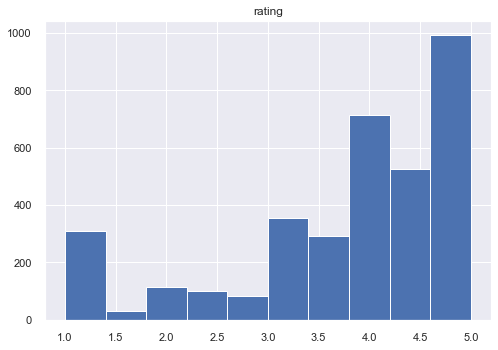

In [43]:
avg_rating.hist()
plt.savefig('./Figures/average_rating_plot.jpg')

We want to show the five hotels with highest ratings and five hotels with lowest ratings

In [44]:
avg_rating.nlargest(5, 'rating')

,rating
name,
1906 Lodge At Coronado Beach,5.0
250 Main Hotel,5.0
AC Hotel Miami Beach,5.0
AC Hotel by Marriott Boston Downtown,5.0
Acadia Suites,5.0


In [45]:
avg_rating.nsmallest(5, 'rating')

,rating
name,
11th Avenue Hotel Hostel,1.0
A Swallow's Nest Motel,1.0
Admiral's Ocean Inn,1.0
Adria Motor Inn,1.0
Advance Motel,1.0


We see that the five hotels with lowest ratings all have ratings of 1.0 and the five hotels with highest ratings all have ratings of 5.0. However, an average rating might be biased for hotels with only 1 rating. Thus, we look into the number of ratings for all hotels

In [46]:
avg_rating['num_rating'] = hotel_grouped.size()

In [47]:
avg_rating.nlargest(5, 'rating')

,rating,num_rating
name,,
1906 Lodge At Coronado Beach,5.0,1
250 Main Hotel,5.0,2
AC Hotel Miami Beach,5.0,1
AC Hotel by Marriott Boston Downtown,5.0,1
Acadia Suites,5.0,2


In [48]:
avg_rating.nsmallest(5, 'rating')

,rating,num_rating
name,,
11th Avenue Hotel Hostel,1.0,1
A Swallow's Nest Motel,1.0,1
Admiral's Ocean Inn,1.0,2
Adria Motor Inn,1.0,1
Advance Motel,1.0,1


Indeed, we see that all these hotels with "lowest" and "highest" ratings only have 1 or 2 ratings. We investigate this further

In [49]:
print("Number of hotels with exactly 1 rating:", avg_rating[avg_rating['num_rating'] == 1].shape[0])
print("Number of hotels with more than 1 rating:", avg_rating[avg_rating['num_rating'] > 1].shape[0])
print("Number of hotels with more than 2 ratings:", avg_rating[avg_rating['num_rating'] > 2].shape[0])

Number of hotels with exactly 1 rating: 1212
Number of hotels with more than 1 rating: 2305
Number of hotels with more than 2 ratings: 1768


In fact, only 2,305 hotels out of 3,517 hotels have more than 1 rating and only 1,768 hotels have more than 2 ratings. If we were to only consider hotels with at least 5 ratings, the top and bottom hotels are as followed:

In [50]:
avg_rating[avg_rating['num_rating'] > 5].nsmallest(5, 'rating')

,rating,num_rating
name,,
The Litchfield Inn,1.000000,13
Norwood Inn and Suites,1.446154,65
Fiesta Inn and Suites,1.454212,546
Seattle Pacific Hotel,1.461538,13
Deluxe Inn Merrillville,1.571429,7


In [51]:
avg_rating[avg_rating['num_rating'] > 5].nlargest(5, 'rating')

,rating,num_rating
name,,
Aloft Philadelphia Downtown,5.0,16
Arrowhead Motel and Rv Park,5.0,11
Bardessono,5.0,8
Chocolate Turtle Bed and Breakfast,5.0,15
Cougar Crest Lodge,5.0,10


<h2> Hotel Categories </h2>

We start by counting the frequency of hotels categories

In [52]:
hotel_categories = df['categories'].str.split(",").explode()
hotel_categories.value_counts()

Hotels                      46819
Hotel                       27094
Lodging                     11168
Hotels Motels                8257
Hotels and motels            6846
                            ...  
Electronic publishing           1
Party Planning Service          1
Outdoors                        1
Hotel and Pool                  1
Gyms and Fitness Centers        1
Name: categories, Length: 572, dtype: int64

However, we see that some categories clearly overlap (e.g., Hotels and hotel). Thus, we perform some text cleaning to collapse them. In particular, we lowercase and tokenize the category, remove stopwords, and convert each token to its base form via lemmatization. In addition, to remove special symbols such as &, we only consider categories that have at least two characters

In [53]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer 

nltk.download("stopwords", quiet = True)
lemmatizer = WordNetLemmatizer()
english_stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_category(text):
    return [
        lemmatizer.lemmatize(token)
        for token in nltk.word_tokenize(text.lower())
        if token not in english_stopwords and len(token) > 1
    ]

hotel_categories = hotel_categories.apply(clean_category).explode()

<AxesSubplot:>

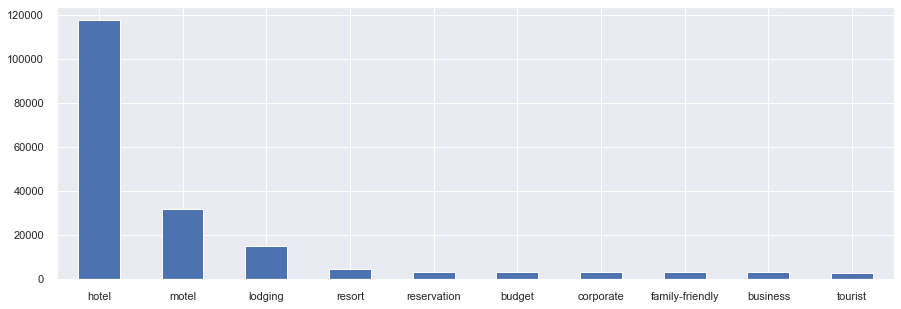

In [54]:
hotel_categories.value_counts().nlargest(10).plot(kind = "bar", rot = 0, figsize = (15, 5))

In [55]:
plt.savefig('./Figures/hotel_categories.jpg')

<Figure size 576x396 with 0 Axes>

In [56]:
hotel_categories.value_counts().nlargest(10)

hotel              117620
motel               31484
lodging             14834
resort               4338
reservation          3280
budget               3193
corporate            3187
family-friendly      3151
business             3024
tourist              2664
Name: categories, dtype: int64

Showing the 10 most common hotel categories, we see that after hotel, motel and lodging on one hand and resort on another hand are also quite popular

<h2> Review dates </h2>

Presumably people would write their review to a hotel shortly after their stay, so looking at the review count at a particular time would provide some insights into a hotel's traffic at that time.

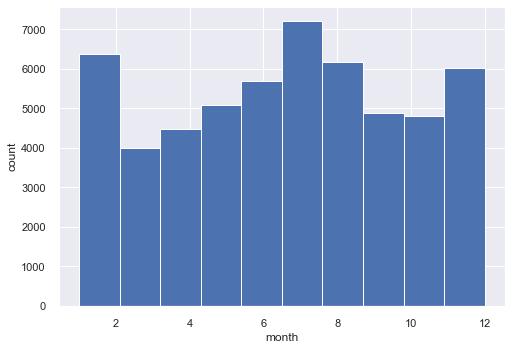

In [57]:
df['month'] = pd.to_datetime(df['date']).dt.month
ax = df['month'].hist()
ax.set_xlabel('month')
ax.set_ylabel('count');
plt.savefig('./Figures/review_count_by_month.jpg')

We see that the three clear modes are in January, July, and December. These three months correspond to the New Year holiday, summer holiday, and Christmas, so it makes sense that they yielded the highest number of guests and reviews.

<h2> Distribution of ratings by month </h2>

Could we try to see if the ratings tend to be higher at certain times of the year than at other times?

In [58]:
month_rating_grouped = df.groupby(['month', 'rating'])
month_rating_grouped.size().unstack()

rating,1.00,1.25,1.30,1.45,1.50,1.65,1.90,2.00,2.10,2.30,...,4.25,4.30,4.40,4.50,4.60,4.70,4.75,4.80,4.90,5.00
month,,,,,,,,,,,,,,,,,,,,,
1.0,176.0,NaN,NaN,NaN,5.0,1.0,NaN,213.0,NaN,2.0,...,1.0,16.0,8.0,5.0,13.0,NaN,NaN,21.0,1.0,1371.0
2.0,221.0,NaN,NaN,1.0,5.0,NaN,NaN,210.0,1.0,1.0,...,NaN,3.0,12.0,NaN,10.0,NaN,NaN,18.0,NaN,1339.0
3.0,322.0,2.0,NaN,NaN,3.0,1.0,NaN,263.0,4.0,1.0,...,NaN,1.0,10.0,4.0,23.0,NaN,NaN,23.0,NaN,1672.0
4.0,334.0,NaN,1.0,1.0,3.0,2.0,1.0,338.0,NaN,NaN,...,NaN,NaN,12.0,NaN,13.0,NaN,NaN,19.0,2.0,1862.0
5.0,368.0,NaN,NaN,2.0,1.0,1.0,NaN,347.0,3.0,3.0,...,NaN,NaN,13.0,NaN,21.0,NaN,NaN,15.0,2.0,2036.0
6.0,513.0,1.0,NaN,3.0,5.0,NaN,NaN,439.0,NaN,3.0,...,NaN,NaN,15.0,1.0,13.0,1.0,NaN,27.0,NaN,2190.0
7.0,670.0,NaN,NaN,NaN,10.0,NaN,2.0,620.0,2.0,1.0,...,NaN,NaN,17.0,1.0,26.0,1.0,1.0,23.0,NaN,2646.0
8.0,538.0,NaN,NaN,NaN,9.0,NaN,1.0,535.0,1.0,1.0,...,1.0,NaN,12.0,NaN,36.0,1.0,1.0,33.0,1.0,2269.0
9.0,402.0,NaN,NaN,NaN,2.0,2.0,NaN,409.0,NaN,2.0,...,NaN,NaN,7.0,1.0,18.0,NaN,NaN,19.0,NaN,1939.0


It is a bit hard to see the distribution this way, so we can classify the ratings into groups

In [59]:
rating_categories = ["Very bad", "Moderately bad", "Neutral", "Moderately good", "Very good"]
df['rating_category'] = df['rating'].apply(lambda r: rating_categories[int(r) - 1])

In [60]:
month_rating_cat_grouped = df.groupby(['month', 'rating_category'])
month_rating_df = month_rating_cat_grouped.size().unstack()[rating_categories]
month_rating_df

rating_category,Very bad,Moderately bad,Neutral,Moderately good,Very good
month,,,,,
1.0,182,227,453,950,1371
2.0,227,258,460,916,1339
3.0,328,298,563,1146,1672
4.0,342,366,613,1302,1862
5.0,372,363,820,1502,2036
6.0,522,455,886,1643,2190
7.0,682,657,1208,2016,2646
8.0,548,568,1001,1783,2269
9.0,406,434,757,1347,1939


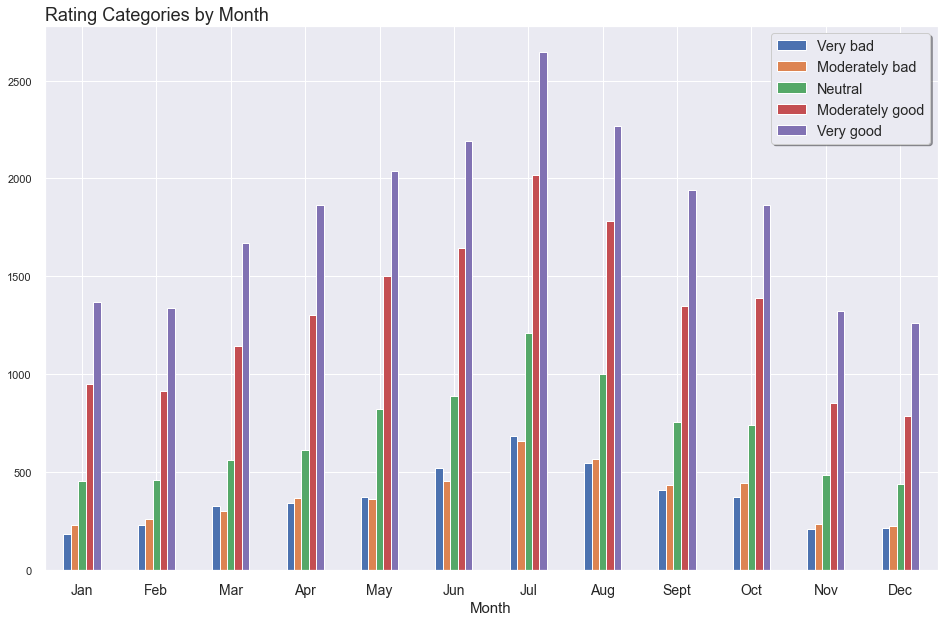

In [61]:
x = [0,1,2,3,4,5,6,7,8,9,10,11]
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
month_rating_df.plot(kind = 'bar', rot = 0, figsize = (16, 10))   
plt.xlabel('Month',fontsize = 15)
plt.xticks(x,labels=months,fontsize=14)
plt.title('Rating Categories by Month',fontsize=18,loc='left')
plt.legend(fontsize='large', shadow='True', frameon='True')
plt.savefig('./Figures/review_cats_by_month.jpg')
# Make this larger and plot a time series graph for each category/rating.

As we expected from the rating distribution earlier, most reviews are relatively position. Additionally, we can see that even though January, July, and December have the most reviews, July is the month with the most positive reviews. Perhaps this means in the summer, people tend to leave better reviews than other seasons.

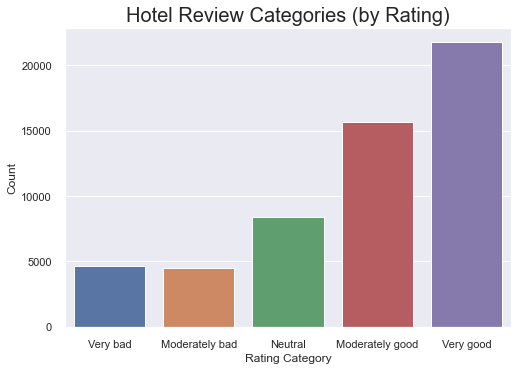

In [62]:
plt.clf()  # clears previous plot
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 8]
sns.countplot(df.rating_category, order = rating_categories)
plt.title("Hotel Review Categories (by Rating)", fontsize = 20)
plt.xlabel("Rating Category", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.savefig('./Figures/review_5cat_bargraph.jpg')

We see that we have many more good reviews than bad reviews.  Given a traveler's perspective, one will prefer higher ratings.  Thus, we increase the cutoff points for what considered as "good" reviews

In [63]:
def rating_bins(r):
    if r == 5:
        return "Very good"
    elif r < 5 and r >= 4:
        return "Mediocre"
    else:
        return "Bad"

get_bins = lambda r: rating_bins(r)

In [64]:
df['alt_rating_category'] = df.rating.apply(get_bins)
df

,address,categories,city,country,latitude,longitude,name,postalCode,province,date,rating,text,title,userCity,username,userProvince,month,rating_category,alt_rating_category
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN,9.0,Moderately good,Mediocre
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN,4.0,Very good,Very good
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN,5.0,Very good,Very good
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN,10.0,Very good,Very good
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN,3.0,Very good,Very good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55907,215 S Pacific St,"Hotel,Hotels,Lodging,Motels",Rockaway Beach,US,45.611260,-123.945560,Silver Sands Oceanfront Motel,97136-9596,OR,2016-03-13T00:00:00Z,3.0,It is hard for me to review an oceanfront hote...,Picture Window Ocean View!,Wildwood,LASH0211,GA,3.0,Neutral,Bad
55908,669 Route 6a,"Hotel,Hotels",East Sandwich,US,41.729390,-70.399250,Sandy Neck Motel,02537-1472,MA,2015-12-11T00:00:00Z,4.0,"I live close by, and needed to stay somewhere ...","Clean, comfortable and quiet",East Sandwich,Gennaker,MA,12.0,Moderately good,Mediocre
55909,702 W Appleway Ave,"Hotel,Hotel, Motel, and Building,Hotels,Lodgin...",Coeur d'Alene,US,47.699930,-116.796900,Shilo Inn Suites - Coeur d'Alene,83814-9338,ID,2017-11-17T00:00:00.000Z,4.0,Rolled in 11:30 laid out heads down woke up to...,Passing through,Montana,Amber406,UnitedStates,11.0,Moderately good,Mediocre
55910,2295 N Highland Ave,"Hotel,Hotels Motels,Budget Hotels,Hotels & Motels",Jackson,US,35.666390,-88.830120,Scottish Inn,38305-4922,TN,2016-06-09T00:00:00Z,1.0,Absolutely terrible..I was told I was being gi...,Terrible,woodbury,donWoodbury,NaN,6.0,Very bad,Bad


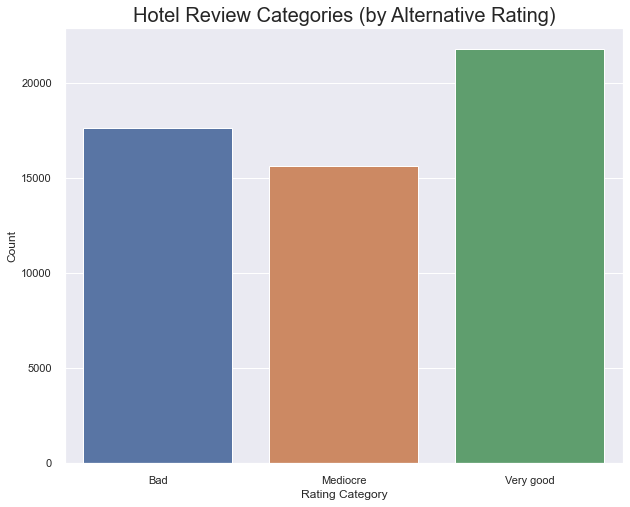

In [65]:
alt_rating_categories = ['Bad', 'Mediocre', 'Very good']
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 8]
sns.countplot(df.alt_rating_category, order = alt_rating_categories)
plt.title("Hotel Review Categories (by Alternative Rating)", fontsize = 20)
plt.xlabel("Rating Category", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.savefig('./Figures/review_3cat_bargraph.jpg')

<h2> Reviews Wordclouds</h2>

<h3> Considering all reviews </h3>

We can populate the word clouds for all reviews to see what reviewers care about the most

In [66]:
df['review'] = df['title'] + ' ' + df['text']
df['review']

0        Good location away from the crouds Pleasant 10...
1        Great hotel with Jacuzzi bath! Really lovely h...
2        Lugnt l��ge Ett mycket bra hotell. Det som dro...
3        Good location on the Lido. We stayed here for ...
4        ������ ��������������� We stayed here for four...
                               ...                        
55907    Picture Window Ocean View! It is hard for me t...
55908    Clean, comfortable and quiet I live close by, ...
55909    Passing through Rolled in 11:30 laid out heads...
55910    Terrible Absolutely terrible..I was told I was...
55911    Polde Filthy, outdated, noisy neighbours, but ...
Name: review, Length: 55027, dtype: object

In [67]:
text=''
for rev in df['review']:
    text += rev
    
title=''
for tle in df['title']:
    title += tle
    
reviews=''
for rev in df['text']:
    reviews += rev

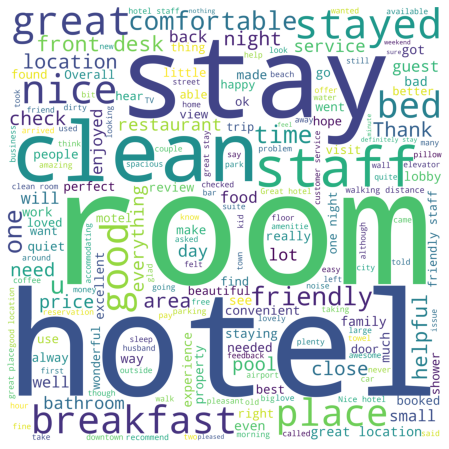

<Figure size 720x576 with 0 Axes>

In [68]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',width = 3000,height = 3000).generate(text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()
plt.savefig('./Figures/raw_data_wordcloud.jpg')

We see that the most common words are actually "hotel", "room", and "stay", which makes sense, but does not give us much insight. That is, words such as these may not provide value in prediction as they appear so frequently. Thus, we remove these three words and build the word cloud again. Additionally, we want to exclude "I" and "s" which appear frequently in reviews.

In [69]:
def remove_words(text_string, DELETE_WORDS = []):
    text_string = text_string.lower()
    for word in DELETE_WORDS:
        if len(word) == 1: 
            text_string = text_string.replace(' ' + word + ' ',' ')
        else:
            text_string = text_string.replace(word,' ')
    return text_string

def clean_text(all_reviews):
    text = ''
    for rev in all_reviews:
        text += rev
    text = remove_words(text, ['hotel', 'room', 'stay', 'I', 's', 'ed', 'u', 'b'])
    return text

In [70]:
#Remove short words
def remove_short_words(text_string, min_length = 0):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' ' + word + ' ',' ')
    return text_string

In [71]:
text = clean_text(df['review'])

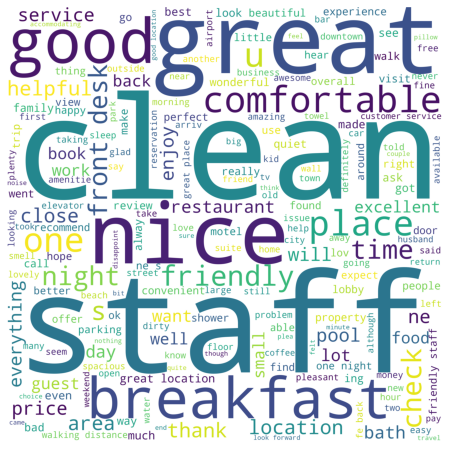

<Figure size 720x576 with 0 Axes>

In [72]:
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',width = 3000,height = 3000).generate(text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()
plt.savefig('./Figures/clean_data_wordcloud.jpg')

In [73]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict
import pprint

Getting rid of end of line characters

In [74]:
# # WARNING -- THIS TAKES VERY LONG TO RUN
# striptext = text.replace('\n\n', ' ')
# striptext = striptext.replace('\n', ' ')

# words = word_tokenize(striptext)
# lowercase_words = [word.lower() for word in words
#                   if word not in stopwords.words() and word.isalpha()]

Construct word frequencies and list the most commonly used words in reviews

In [75]:
# # WARNING -- THIS TAKES VERY LONG TO RUN
# word_frequencies = FreqDist(lowercase_words)
# most_frequent_words = FreqDist(lowercase_words).most_common(20)
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(most_frequent_words)

After excluding words like 'hotel', 'room', 'stay', we observe that 'great', 'staff', 'clean' are some of the most frequently used words in reviews, indicating that are more reviews with positive words than they are reviews with negative words. This aligns well with the fact that we have more positive reviews than negative reviews.

From this we see that many reviews mention "clean" and "staff", suggesting that cleanliness and the behavior of hotel staff are something that matter to customers and may influence their rating of the hotel.

We also see some mentions of "breakfast", "location", "front desk", etc. These are also some features that customer pay attention to.

<h3> Considering good reviews and bad reviews </h3>

Would the word clouds be any different for the very good reviews (rating 5.0) and the very bad reviews (rating 1.0)?

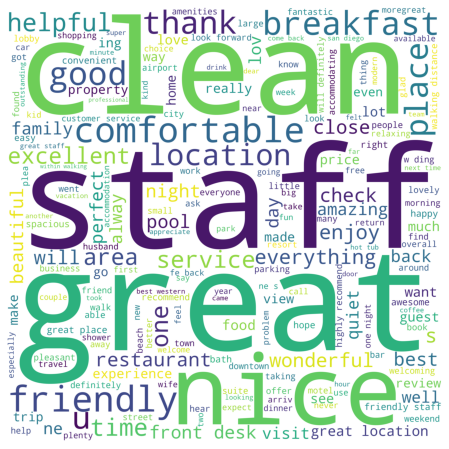

<Figure size 720x576 with 0 Axes>

In [76]:
good_reviews = df[df['rating'] == 5.0]['review']

good_text = clean_text(good_reviews)
    
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',width = 3000,height = 3000).generate(good_text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()
plt.savefig('./Figures/five_star_rating_wordcloud.jpg')

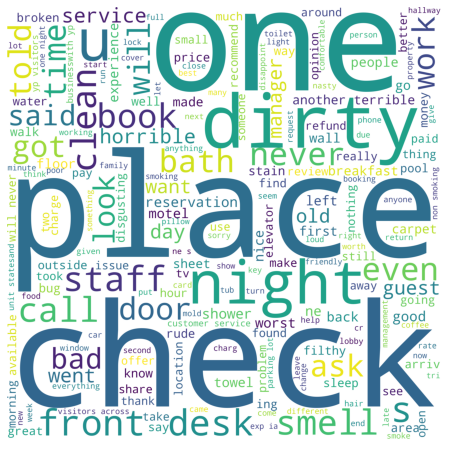

<Figure size 720x576 with 0 Axes>

In [77]:
bad_reviews = df[df['rating'] == 1.0]['review']

bad_text = clean_text(bad_reviews)
    
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',width = 3000,height = 3000).generate(bad_text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()
plt.savefig('./Figures/1star_rating_wordcloud.jpg')

We can see that the good reviews mention a lot of "clean" and "staff", other than the obvious "great". There are also a lot of mentions of "friendly", "helpful", "comfortable", "convenient", "location", which all hint that the good hotels are the one that are clean and comfortable, with friendly and helpful staff, and at a convenient location.

On the other hand, the bad reviews are the one about hotels that are "dirty", "booked", or even "smelled".

In [78]:
# five_star_reviews = df[df['rating'] == 5.0]['review']
# good_reviews = df[(df.rating >=4.0) & (df['rating'] < 5.0)]['review']
# moderate_reviews = df[(df.rating >=3.0) & (df['rating'] < 4.0)]['review']
# bad_reviews = df[(df.rating > 1.0) & (df['rating'] < 3.0)]['review']
# one_star_reviews = df[df['rating'] == 1.0]['review']

# five_star_text = clean_text(five_star_reviews)
# good_text = clean_text(good_reviews)
# moderate_text = clean_text(moderate_reviews)
# bad_text = clean_text(bad_reviews)
# one_star_text = clean_text(one_star_reviews)


# all_reviews = [('Five-Star Reviews $(R = 5)$', five_star_text), 
#                ('Good Reviews $(4 \leq R < 5)$', good_text), 
#                ('Moderate Reviews $(3 \leq R < 4)$',moderate_text),
#                ('Bad Reviews $(1< R < 3)$', bad_text),
#               ('One-Star Reviews $(R = 1)$',one_star_text)]

# COL_NUM = 2
# ROW_NUM = 3
# fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(13,13))
# fig.delaxes(axes[2,1]) # deletes the 6th plot instance (since we are computing an odd number of plots)

# for i in range(0,len(all_reviews)):
# #     hotel_reviews = df[df['name'] == hotel_name]['review']
#     hotel_reviews = clean_text(all_reviews[i][1])
#     ax = axes[i//2, i%2] 
#     ax.set_title(all_reviews[i][0], fontsize=15, fontweight='bold')
#     wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=1200,height=1000,max_words=20).generate(hotel_reviews)
#     ax.imshow(wordcloud)
#     ax.axis('off')

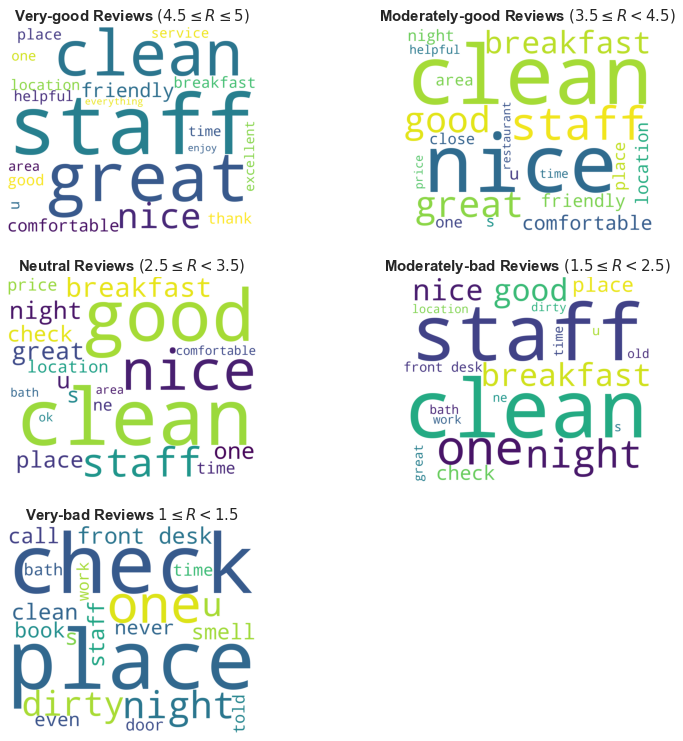

In [79]:
very_good_reviews = df[df['rating_category'] == 'Very good']['review']
moderately_good_reviews = df[df['rating_category'] == 'Moderately good']['review']
neutral_reviews = df[df['rating_category'] == 'Neutral']['review']
moderately_bad_reviews = df[df['rating_category'] == 'Moderately bad']['review']
very_bad_reviews = df[df['rating_category'] == 'Very bad']['review']

all_reviews = [('Very-good Reviews $(4.5 \leq R \leq 5)$', very_good_reviews), 
               ('Moderately-good Reviews $(3.5 \leq R < 4.5)$', moderately_good_reviews), 
               ('Neutral Reviews $(2.5 \leq R < 3.5)$',neutral_reviews),
               ('Moderately-bad Reviews $(1.5 \leq R < 2.5)$', moderately_bad_reviews),
               ('Very-bad Reviews $1 \leq R < 1.5$',very_bad_reviews)]

COL_NUM = 2
ROW_NUM = 3
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(13,13))
fig.delaxes(axes[2,1]) # deletes the 6th plot instance (since we are computing an odd number of plots)

for i in range(0,len(all_reviews)):
#     hotel_reviews = df[df['name'] == hotel_name]['review']
    hotel_reviews = clean_text(all_reviews[i][1])
    ax = axes[i//2, i%2] 
    ax.set_title(all_reviews[i][0], fontsize=15, fontweight='bold')
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=1200,height=1000,max_words=20).generate(hotel_reviews)
    ax.imshow(wordcloud)
    ax.axis('off')

plt.savefig('./Figures/5cat_wordclouds.jpg')

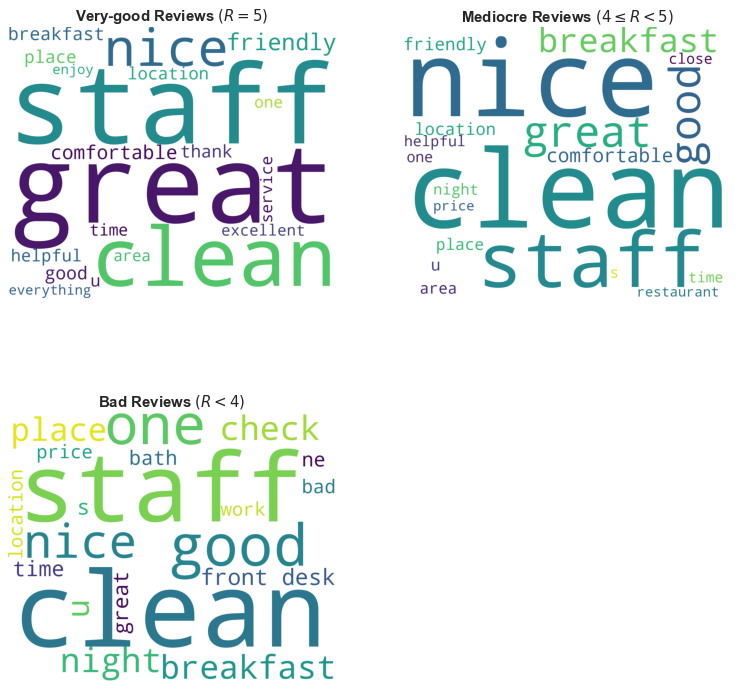

In [80]:
very_good_reviews = df[df['alt_rating_category'] == 'Very good']['review']
mediocre_reviews = df[df['alt_rating_category'] == 'Mediocre']['review']
bad_reviews = df[df['alt_rating_category'] == 'Bad']['review']

all_reviews = [('Very-good Reviews $(R = 5)$', very_good_reviews), 
               ('Mediocre Reviews $(4 \leq R < 5)$', mediocre_reviews), 
               ('Bad Reviews $(R < 4)$',bad_reviews)]

COL_NUM = 2
ROW_NUM = 2
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(13,13))
fig.delaxes(axes[1,1]) # deletes the 4th plot instance (since we are computing an odd number of plots)

for i in range(0,len(all_reviews)):
#     hotel_reviews = df[df['name'] == hotel_name]['review']
    hotel_reviews = clean_text(all_reviews[i][1])
    ax = axes[i//2, i%2] 
    ax.set_title(all_reviews[i][0], fontsize=15, fontweight='bold')
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=1200,height=1000,max_words=20).generate(hotel_reviews)
    ax.imshow(wordcloud)
    ax.axis('off')

plt.savefig('./Figures/3cat_wordclouds.jpg')

Based on the word cloud plots, it appears that for reviews with ratings above 3, many of the most frequently used words are similar (e.g., clean, good, and staff). On the other hand, for reviews with ratings below 3 stars do not to appear to have many frequently used words in common, besides 'one'. In fact, many reviews with ratings between 1 and 3 appear to include words that would otherwise be positive such as 'clean', 'good', and 'nice'. However, the contextual use around these words would need to be evaluated further to make any meaningful conclusions about this.

We can verify these by looking at specific reviews for top hotels and bottom hotels.

<h3> Considering reviews for top hotels and bottom hotels </h3>

To ensure we have enough reviews to generate wordclouds, we consider the 4 best and worst hotels where each hotel has at least 5 reviews

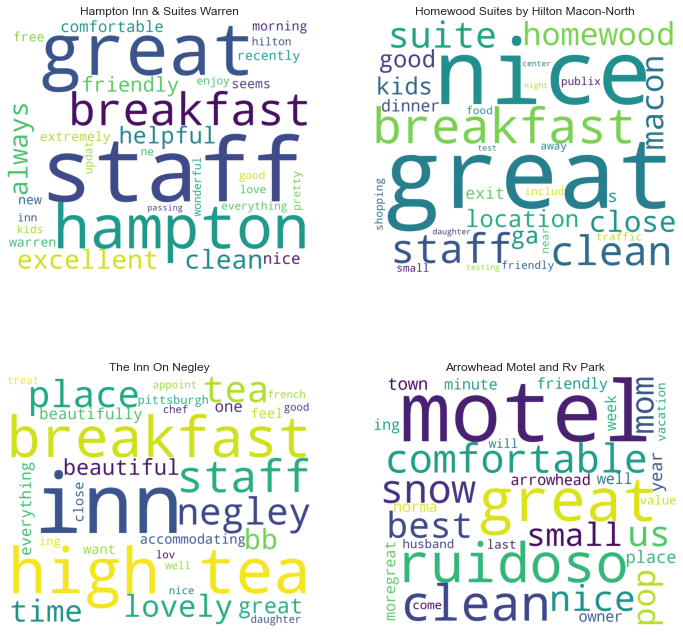

In [81]:
top_hotels_avg_rating = avg_rating[avg_rating['num_rating'] > 5].sort_values(by = 'rating', ascending = False).head(4)
top_hotels_avg_rating.reset_index(level=0, inplace=True)
#top_hotels = df[df['name'].isin(top_hotels_avg_rating['name'])]

top_hotels = []

for hotel_name in top_hotels_avg_rating['name']:
    hotel_reviews = df[df['name'] == hotel_name]['review']
    hotel_text = clean_text(hotel_reviews)
    
    top_hotels.append((hotel_name, hotel_text))
    
#Set up side by side clouds
COL_NUM = 2
ROW_NUM = 2
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i in range(0,len(top_hotels)):
    text_string = top_hotels[i][1]
    
    ax = axes[i//2, i%2] 
    ax.set_title(top_hotels[i][0])
    wordcloud = WordCloud(stopwords = STOPWORDS,background_color='white',width=1200,height=1000,max_words=30).generate(text_string)
    ax.imshow(wordcloud)
    ax.axis('off')

plt.savefig('./Figures/good_hotels_wordclouds.jpg')
plt.show()

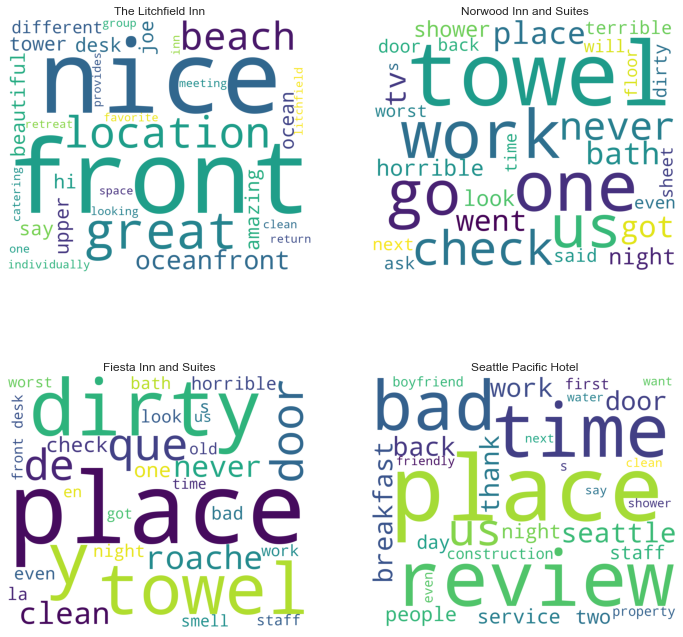

In [82]:
bottom_hotels_avg_rating = avg_rating[avg_rating['num_rating'] > 5].sort_values(by = 'rating').head(4)
bottom_hotels_avg_rating.reset_index(level=0, inplace=True)
#bottom_hotels = df[df['name'].isin(bottom_hotels_avg_rating['name'])]

bottom_hotels = []

for hotel_name in bottom_hotels_avg_rating['name']:
    hotel_reviews = df[df['name'] == hotel_name]['review']
    hotel_text = clean_text(hotel_reviews)
    
    bottom_hotels.append((hotel_name, hotel_text))
    
#Set up side by side clouds
COL_NUM = 2
ROW_NUM = 2
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i in range(0,len(bottom_hotels)):
    text_string = bottom_hotels[i][1]
    
    ax = axes[i//2, i%2] 
    ax.set_title(bottom_hotels[i][0])
    wordcloud = WordCloud(stopwords = STOPWORDS,background_color='white',width=1200,height=1000,max_words=30).generate(text_string)
    ax.imshow(wordcloud)
    ax.axis('off')

plt.savefig('./Figures/bad_hotels_wordclouds.jpg')
plt.show()

<h3> Considering hotels in specific locations </h3>

In [83]:
# df.groupby('province').size()

In [84]:
# !pip install geopy

In [85]:
# # import module
# from geopy.geocoders import Nominatim
  
# # initialize Nominatim API
# geolocator = Nominatim(user_agent = "geoapiExercises", timeout = 10)
  
# # Latitude & Longitude input
# Latitude = "45.421611"
# Longitude = "12.376187"

# location = geolocator.reverse(Latitude+","+Longitude)
  
# address = location.raw['address']
  
# # traverse the data
# city = address.get('city', '')
# state = address.get('state', '')
# country = address.get('country', '')
# code = address.get('country_code')
# zipcode = address.get('postcode')
# print('City : ', city)
# print('State : ', state)
# print('Country : ', country)
# print('Zip Code : ', zipcode)

In [86]:
# df['lat_long'] = df['latitude'].map(str) + ',' + df['longitude'].map(str)
# df

In [87]:
# # import module
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter
# #import tqdm
# #from tqdm._tqdm_notebook import tqdm_notebook
  
# # initialize Nominatim API
# geolocator = Nominatim(user_agent = "geoapiExercises", timeout = 10)

# rgeocode = RateLimiter(geolocator.reverse, min_delay_seconds = 0.00001)

# #tqdm.pandas()
# #df['state'] = df['lat_long'].progress_apply(rgeocode)
# test = df.head(5)

# test['address'] = test['lat_long'].apply(rgeocode).address
# #test['state'] = test['address'].raw['address']

# test

In [88]:
# df.head(5)

In [89]:
# !pip install geocoder

In [90]:
# import geocoder

# def geo_rev(x):
#     g = geocoder.osm([x.latitude, x.longitude], method = 'reverse').json
#     if g:
#         return g.get('state')
#     else:
#         return 'no state'

# df[['latitude', 'longitude']].apply(geo_rev, axis = 1)

<h3> Data Filtering, Exclusions, and Segmentation Analysis </h3>

In [91]:
df_int = df.copy()
df_int.rating = df_int.rating.astype(int)

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [93]:
#plt.scatter(x = df_int.longitude, y=df_int.latitude, marker='.')

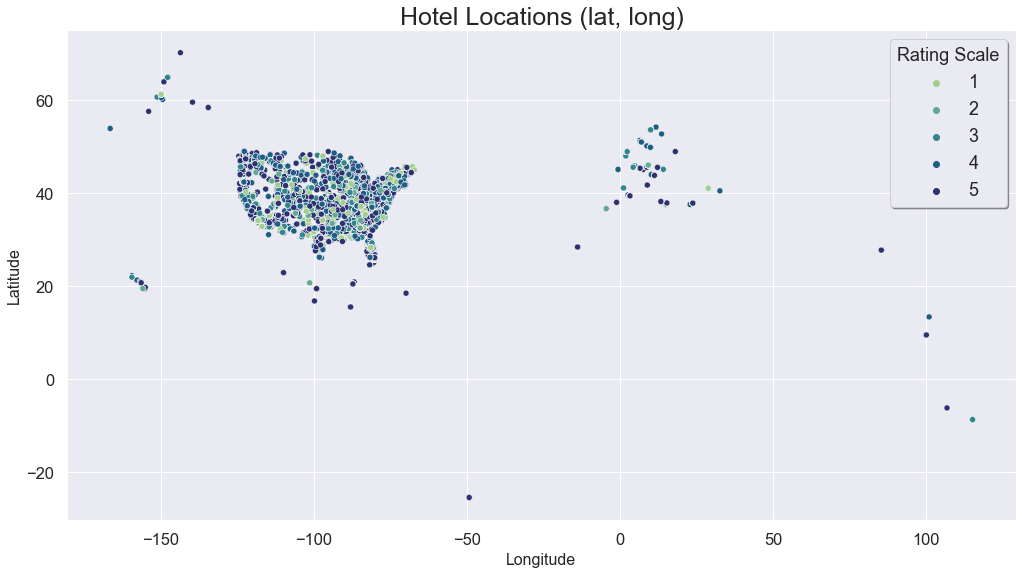

In [94]:
sns.set(rc={"figure.figsize":(17, 9)}, font_scale=1.5) 
p=sns.scatterplot(data=df_int, x='longitude', y='latitude', hue='rating',
                markers='.', legend='full',palette='crest')

p.set_title('Hotel Locations (lat, long)', fontsize = 25)
p.set_xlabel("Longitude", fontsize = 16)
p.set_ylabel("Latitude", fontsize = 16)
plt.legend(fontsize='medium', title='Rating Scale', shadow='True', frameon='True')
plt.savefig('./Figures/hotel_loc.jpg')

Most of the reviews appear to be in the U.S.. We also see that the ratings appear to be evenly distributed with respect to location.

In [95]:
df.country.unique()

array(['US'], dtype=object)

Despite the plot showing that there are reviews outside of the U.S., the country column indicates that all reviews are in the U.S.. It's not clear if this will have any impact on model performance.

In [96]:
df_US = df[((df['latitude']<=50.0) & (df['latitude']>=24.0)) & 
         ((df['longitude']<=-65.0) & (df['longitude']>=-122.0))]

In [97]:
print('There are',len(df) - len(df_US),'reviews outside the U.S.')

There are 8093 reviews outside the U.S.


Filtering out all locations outside of the U.S.

In [98]:
df = df[((df['latitude']<=50.0) & (df['latitude']>=24.0)) & 
         ((df['longitude']<=-65.0) & (df['longitude']>=-122.0))]

In [99]:
df_new = df.copy()
df_new.rating = df_new.rating.astype(int)

Plot another scatter plot, but on the truncated dataset (constrained to only those hotel reviews within the U.S.).

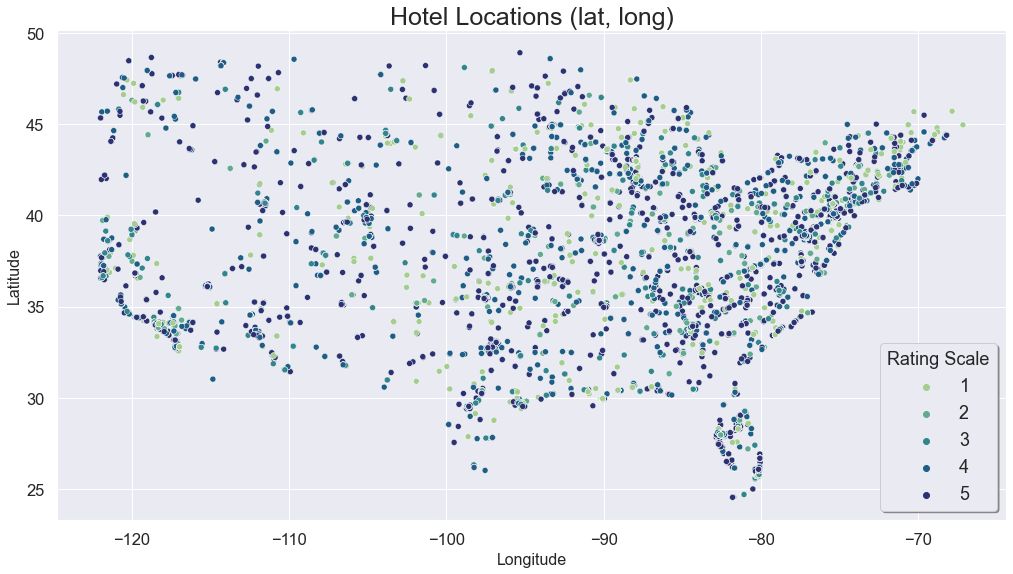

In [100]:
sns.set(rc={"figure.figsize":(17, 9)}, font_scale=1.5) 
p=sns.scatterplot(data=df_new, x='longitude', y='latitude', hue='rating',
                markers='.', legend='full',palette='crest')

p.set_title('Hotel Locations (lat, long)', fontsize = 25)
p.set_xlabel("Longitude", fontsize = 16)
p.set_ylabel("Latitude", fontsize = 16)
plt.legend(fontsize='medium', title='Rating Scale', shadow='True', frameon='True')
plt.savefig('./Figures/hotel_us_loc.jpg')

# Feature Engineering (text mining)

The only data we have is the short text extract. So, we will use several text mining technics in order to extract useful features.

In [ ]:
# Normalization over number of words
def normalization_word(var):
    """Returns number of words."""
    words = nltk.Text(word_tokenize(((var))))
    return len(words)

# Normalization by number of Sentences
def normalization_sentence(var):
    """Returns number of sentences."""
    sentences = nltk.Text(sent_tokenize(var))
    return len(sentences)

# Normalization by number of Characters
def normalization_character(var):
    """Returns number of characters."""
    return len(var)

def cleaning(var):
    """Take a string. Returns a string with only lowercase letters and the space between words."""
    plain_string = ""
    for x in var:
        x = x.lower()
        if (('a' <= x and x <= 'z') or x == ' '):
            plain_string += x
        elif x == '\'':  # any apostrophes(') are replaced by a space
            plain_string += ' '
    while '  ' in plain_string:  # any multiple spaces are replaced by a single space
        plain_string = plain_string.replace('  ', ' ')
    return plain_string

In [ ]:
# df['review'] = df['title'] + ' ' + df['text']
# df = df[df.review.apply(lambda x: len(str(x)) > 12)]

# def review_transform(t):
#     temp = t.encode('ascii', 'ignore').decode('utf-8').strip() #transform unrecognized text      
#     if len(temp) > 12 and any(c.isalpha() for c in temp): #min length of review is 12, must contain character
#         if detect(temp) != 'en':
#             temp = GoogleTranslator(source='auto', target='en').translate(temp)
            
#     return temp
    
# df['review'] = df['review'].apply(lambda t: review_transform(t))
# df = df[df['review'].apply(lambda x: len(x) > 12)]

In [ ]:
# #testing translator
# to_translate = '我想吃饭'
# translated = GoogleTranslator(source='auto', target='en').translate(to_translate)
# translated

In [ ]:
#df.to_csv('cleaned_review_df.csv')

<h1> Predicting reviews rating from reviews text and title </h1>

<h2> Features Engineering using TD-IDF and Prepare training and testing datasets </h2>

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.3, random_state = 28)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train['review'])
#X_train.A

In [ ]:
y_train = train['rating']
#y_train

In [ ]:
X_test = vectorizer.transform(test['review'])
y_test = test['rating']
#X_test.A

<h2> Model Development </h2>

<li> Train various regression models
<li> Transform non-integer ratings to integers
<li> Train multiclassification models using integer ratings
<li> Group ratings into two categories, 'Good' and 'Bad', which will be denoted by a 1 and 0, respectively.
<li> Train binary classification models on binary-{0,1} dependent variable

Notice above in our EDA that many user ratings are not integers. Based on this, we will initially train a set of regression models and evaluate their performance and then train multi- and binary classifiers after transforming the ratings variable.

In [ ]:
def fit_reg_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
    
    model_r2 = r2_score(y_test, y_pred)
    model_mse = mean_squared_error(y_test, y_pred)
    model_evs = explained_variance_score(y_test, y_pred)
    
    return model_r2, model_mse, model_evs

<h3> Using Linear Regression </h3>

In [ ]:
# from sklearn import linear_model

# lin_reg = linear_model.LinearRegression() # an empty model
# lin_r2, lin_mse, lin_evs = fit_reg_model(lin_reg)

<h3> Using Decision Tree </h3>

In [ ]:
# from sklearn.tree import DecisionTreeRegressor

# dct_reg = DecisionTreeRegressor(max_depth = 5)
# dct_r2, dct_mse, dct_evs = fit_model(dct_reg)

<h3> Using Random Forest </h3>

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# rf_reg = RandomForestRegressor(max_depth = 5, random_state = 0)
# rf_r2, rf_mse, rf_evs = fit_reg_model(rf_reg)

<h3> Using Nearest Neighbors </h3>

In [ ]:
# from sklearn.neighbors import KNeighborsRegressor

# knn_reg = KNeighborsRegressor(n_neighbors = 2)
# knn_r2, knn_mse, knn_evs = fit_reg_model(knn_reg)

<h3> Using Multi-layer Perceptron </h3>

In [ ]:
# from sklearn.neural_network import MLPRegressor

# mlp_reg = MLPRegressor(random_state = 1, max_iter = 500)
# mlp_r2, mlp_mse, mlp_evs = fit_reg_model(mlp_reg)

<h3> Using Support Vector Machines </h3>

In [ ]:
# from sklearn.svm import LinearSVR

# svm_reg = LinearSVR()
# svm_r2, svm_mse, svm_evs = fit_reg_model(svm_reg)

<h4> Compare Model Performance of Regression models</h4>

In [ ]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR


lin_reg = linear_model.LinearRegression() 
dct_reg = DecisionTreeRegressor(max_depth = 5)
rf_reg = RandomForestRegressor(max_depth = 5, random_state = 0)
knn_reg = KNeighborsRegressor(n_neighbors = 2)
mlp_reg = MLPRegressor(random_state = 1, max_iter = 500)
svm_reg = LinearSVR()

all_reg_models = [lin_reg, dct_reg, rf_reg, knn_reg, mlp_reg, svm_reg]
reg_models_perf = []

for model in all_reg_models:
    model_r2, model_mse, model_evs = fit_reg_model(model)
    reg_models_perf.append({'R-quared':model_r2, 'Mean squared error' : model_mse, 'Explained variance score': model_evs})
    
reg_models_df = pd.DataFrame(reg_models_perf)

In [ ]:
reg_models_df['Model'] = ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 
                          'Nearest Neighbors Regressor', 'Multi-layer Perceptron', 'Support Vector Machine']
reg_models_df.set_index('Model', inplace = True)
reg_models_df

<h2> Multiclass classification model development </h2>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import svm
# from xgboost import XGBClassifier
# import xgboost as xgb
from sklearn import model_selection

import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import pylab as pl
import matplotlib.pyplot as plt
# import dsml.plot
from sklearn.model_selection import GridSearchCV

In [ ]:
integer_ratings = []
for rating in df['rating']:
    integer_ratings.append(np.rint(rating))  # rounds ratings to nearest integer
    
df['integer rating'] = integer_ratings

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')

X_train,X_test,y_train,y_test = train_test_split(tfidf_vectorizer.fit_transform(df['review']).toarray(),
                                                 df['integer rating'].values,test_size = 0.2,
                                                 random_state=123)

feature_names = tfidf_vectorizer.get_feature_names()
feature_names

In [ ]:
def get_clf_predictions(X_train,y_train,X_test):
    dt_model = DecisionTreeClassifier(random_state=123).fit(X_train,y_train)
    rf_model = RandomForestClassifier(random_state=123).fit(X_train,y_train)
    #bag_model = BaggingClassifier(random_state=123).fit(X_train,y_train)
    lr_model = LogisticRegression(random_state=123).fit(X_train,y_train)
#     xgb_model = XGBClassifier(random_state=123).fit(X_train,y_train)
    
    y_score = pd.DataFrame({
        'Decision Tree': dt_model.predict_proba(X_test)[:,1],
        'Random Forest': rf_model.predict_proba(X_test)[:,1],
        #'Bagging Classifier': bag_model.predict_proba(X_test)[:,1],
        'Logistic Regression': lr_model.predict_proba(X_test)[:,1]
#         'XGBoost': xgb_model.predict_proba(X_test)[:,1]
    })
    
    y_pred = pd.DataFrame({
        'Decision Tree': dt_model.predict(X_test),
        'Random Forest': rf_model.predict(X_test),
        #'Bagging Classifier': bag_model.predict(X_test),
        'Logistic Regression': lr_model.predict(X_test)
#         'XGBoost': xgb_model.predict(X_test)
    })
    
    return y_score, y_pred, dt_model, rf_model, lr_model

def get_pr_thresholds(y_test,y_score):
    import numpy as np
    thresholds = np.arange(0, 1, 0.05)
    threshold_list = list(thresholds)
    columns = list(y_score.columns)
    precisions = []
    recall = []
    model_labels = []
    thres_lst = []
    for column in columns:
        for threshold in threshold_list:
            y_pred = (y_score > threshold).astype(int)
            
            precision = precision_score(y_test,y_pred[column])
            recall = recall_score(y_test,y_pred[column])
            label=str(column)
            thres=str(threshold)
            precisions.append(precision)
            recalls.append(recall)
            model_label.append(label)
            thres_lst.append(thres)
    pr_df = pd.DataFrame({'model_label':model_label,
                         'threshold': thres_lst,
                         'precision':precisions,
                         'recall':recalls})
    return pr_df

In [ ]:
y_score5, y_pred5, dt_model5, rf_model5, lr_model5 = get_clf_predictions(X_train,y_train,X_test)

In [ ]:
method=[y_score5['Decision Tree'],y_score5['Random Forest'], y_score5['Logistic Regression']]
model = ['Decision Tree', 'Random Forest', 'Logistic Regression']

fpr = dict()
tpr = dict()

%matplotlib inline
plt.figure(figsize=(8,7))

for i in range(len(method)):
    fpr[i], tpr[i], thresholds = roc_curve(y_test,method[i])
    plt.plot(fpr[i],tpr[i], label=model[i]+'(AUC = %0.2f)'%roc_auc_score(y_test,method[i]))

# fig1, ax1 = plt.subplots(figsize=(8,6))
# ax1.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test,y_score), color='blue')
plt.plot([0, 1],[0, 1], linestyle='--', color='red', label='Random')
# plt.fill_between(fpr, 0, tpr, color='lightgray', alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curves - Multiclass Classification (Five Categories)')
plt.legend(loc="lower right", prop={'family':'sans-serif','size':14.5}, shadow=True)
plt.savefig('./Figures/roc_mult5.jpg')

In [ ]:
pr_thresholds = get_pr_thresholds(y_test,y_score5)
pr_thresholds.sort_values(by=['recall'],ascending=False,inplace=True)
pr_thresholds.head(20)

In [ ]:
plt.clf()
groups = pr_thresholds.groupby('model_label')

#Plot
fig, ax = plt.subplots(figsize = 15,15)
ax.set_xlim([0,1])
ax.set_ylim([0,1])

for name, group in groups:
    ax.plot(group.recall, group.precision, marker='o', linestyle='', ms=12, label=name)

plt.legend(bbox_to_anchor=(0, .5), loc='right', ncol=1)
plt.savefig('./Figures/pr_mult5.jpg')
plt.show()

In [ ]:
plt.clf()
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

#precision, recall, thresholds = precision_recall_curve(y_train, training_predictions)
#average_precision = average_precision_score(y_train, training_predictions)


precision, recall, thresholds = precision_recall_curve(y_test, y_pred5)
average_precision = average_precision_score(y_test, y_pred5)

step_kwargs = ({'step' : 'post'})

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('5-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.savefig('./Figures/pr_curve_mult5.jpg')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Hyperparamter Tuning/Optimization
parameters = {
     'n_estimators':(10, 30, 50), # the number of trees
     'max_depth':(4,5,6,8,10,15), # the maximum depth of each decision tree (you don't want it to be too deep since then nodes would have fewer observations)
     'min_samples_split': (2, 4, 8), # at each intermediate node (non-leaf node), the minimum number of examples/observations in that node. If the number of datapoints is fewer than this h-param, then it won't do the split.
     'min_samples_leaf': (4,8,12,16) # the minimum sample size (# of obs) at each leaf node
}

# model = GridSearchCV(RandomForestClassifier(),parameters,cv=3,iid=False)
model = GridSearchCV(RandomForestClassifier(),parameters,cv=3)
model.fit(X_train,y_train)
model.best_score_, model.best_params_   # prints the best score achieved and the best hyperparameters

In [ ]:
best_params = model.best_params_

In [ ]:
model = RandomForestClassifier(max_depth=15,min_samples_leaf=12,
                               min_samples_split=8,n_estimators=10)
model.fit(X_train,y_train)

In [ ]:
model = RandomForestClassifier(best_params)
model.fit(X_train,y_train)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
importances = model.feature_importances_   # returns an array of importance values
indices = np.argsort(importances)      # the argsort function returns the array of indices of the sorted array (in increasing or decreasing order)
plt.figure(figsize=(12,12))            
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)),feature_names)
plt.yticks(range(len(indices)))
plt.xlabel('Relative Importance')

In [ ]:
sorted(importances, reverse=True)[:30]

In [ ]:
model.score(X_test,y_test)

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer(stop_words='english')
# data_cv = cv.fit_transform(text)
# data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

<h4> Multiclass Classification with three categories (Good, Neutral, Bad) </h4>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import svm
# from xgboost import XGBClassifier
# import xgboost as xgb
from sklearn import model_selection

import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import pylab as pl
# import dsml.plot
from sklearn.model_selection import GridSearchCV

In [ ]:
def multiclass_bins(r):
    if r >= 4 and r <= 5:
        return "Good"
    elif r > 2 and r < 4:
        return "Neutral"
    else:
        return "Bad"

get_mult_bins = lambda r: multiclass_bins(r)

df['multiclass_category'] = df.rating.apply(get_mult_bins)
df

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X_train,X_test,y_train,y_test = train_test_split(vectorizer.fit_transform(df['text']).toarray(),
                                                 df['multiclass_category'].values,test_size = 0.2,
                                                 random_state=123)

In [ ]:
def get_clf_predictions(X_train,y_train,X_test):
    dt_model = DecisionTreeClassifier(random_state=123).fit(X_train,y_train)
    rf_model = RandomForestClassifier(random_state=123).fit(X_train,y_train)
    #bag_model = BaggingClassifier(random_state=123).fit(X_train,y_train)
    lr_model = LogisticRegression(random_state=123).fit(X_train,y_train)
#     xgb_model = XGBClassifier(random_state=123).fit(X_train,y_train)
    
    y_score = pd.DataFrame({
        'Decision Tree': dt_model.predict_proba(X_test)[:,1],
        'Random Forest': rf_model.predict_proba(X_test)[:,1],
        #'Bagging Classifier': bag_model.predict_proba(X_test)[:,1],
        'Logistic Regression': lr_model.predict_proba(X_test)[:,1]
#         'XGBoost': xgb_model.predict_proba(X_test)[:,1]
    })
    
    y_pred = pd.DataFrame({
        'Decision Tree': dt_model.predict(X_test),
        'Random Forest': rf_model.predict(X_test),
        #'Bagging Classifier': bag_model.predict(X_test),
        'Logistic Regression': lr_model.predict(X_test)
#         'XGBoost': xgb_model.predict(X_test)
    })
    
    return y_score, y_pred, dt_model, rf_model, lr_model

def get_pr_thresholds(y_test,y_score):
    import numpy as np
    thresholds = np.arange(0, 1, 0.05)
    threshold_list = list(thresholds)
    columns = list(y_score.columns)
    precisions = []
    recall = []
    model_labels = []
    thres_lst = []
    for column in columns:
        for threshold in threshold_list:
            y_pred = (y_score > threshold).astype(int)
            
            precision = precision_score(y_test,y_pred[column])
            recall = recall_score(y_test,y_pred[column])
            label=str(column)
            thres=str(threshold)
            precisions.append(precision)
            recalls.append(recall)
            model_label.append(label)
            thres_lst.append(thres)
    pr_df = pd.DataFrame({'model_label':model_label,
                         'threshold': thres_lst,
                         'precision':precisions,
                         'recall':recalls})
    return pr_df

In [ ]:
y_score3, y_pred3, dt_model3, rf_model3, lr_model3 = get_clf_predictions(X_train,y_train,X_test)

In [ ]:
method=[y_score3['Decision Tree'],y_score3['Random Forest'], y_score3['Logistic Regression']]
model = ['Decision Tree', 'Random Forest', 'Logistic Regression']

fpr = dict()
tpr = dict()

%matplotlib inline
plt.figure(figsize=(8,7))

for i in range(len(method)):
    fpr[i], tpr[i], thresholds = roc_curve(y_test,method[i])
    plt.plot(fpr[i],tpr[i], label=model[i]+'(AUC = %0.2f)'%roc_auc_score(y_test,method[i]))

# fig1, ax1 = plt.subplots(figsize=(8,6))
# ax1.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test,y_score), color='blue')
plt.plot([0, 1],[0, 1], linestyle='--', color='red', label='Random')
# plt.fill_between(fpr, 0, tpr, color='lightgray', alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curves - Multiclass Classification (Three Categories)')
plt.legend(loc="lower right", prop={'family':'sans-serif','size':14.5}, shadow=True)
plt.savefig('./Figures/roc_mult3.jpg')

In [ ]:
pr_thresholds = get_pr_thresholds(y_test,y_score3)
pr_thresholds.sort_values(by=['recall'],ascending=False,inplace=True)
pr_thresholds.head(20)

In [ ]:
plt.clf()
groups = pr_thresholds.groupby('model_label')

#Plot
fig, ax = plt.subplots(figsize = 15,15)
ax.set_xlim([0,1])
ax.set_ylim([0,1])

for name, group in groups:
    ax.plot(group.recall, group.precision, marker='o', linestyle='', ms=12, label=name)

plt.legend(bbox_to_anchor=(0, .5), loc='right', ncol=1)
plt.savefig('./Figures/pr_mult3.jpg')
plt.show()

In [ ]:
plt.clf()
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

#precision, recall, thresholds = precision_recall_curve(y_train, training_predictions)
#average_precision = average_precision_score(y_train, training_predictions)


precision, recall, thresholds = precision_recall_curve(y_test, y_pred3)
average_precision = average_precision_score(y_test, y_pred3)

step_kwargs = ({'step' : 'post'})

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('3-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.savefig('./Figures/pr_curve_mult3.jpg')
plt.show()

<h3> Binary Classification </h3>

Group ratings into binary categories for binary classification. For ratings less than or equal to 3, the corresponding target response is 0; otherwise, the target response is 1.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import svm
# from xgboost import XGBClassifier
# import xgboost as xgb
from sklearn import model_selection

import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import pylab as pl
# import dsml.plot
from sklearn.model_selection import GridSearchCV

In [ ]:
binary_target = []
for rating in df['rating']:
    if rating <=3:
        binary_target.append(0)
    else:
        binary_target.append(1)
df['binary_target'] = binary_target

In [ ]:
df['binary_target']

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X_train,X_test,y_train,y_test = train_test_split(vectorizer.fit_transform(df['text']).toarray(),
                                                 df['binary_target'].values,test_size = 0.2,
                                                 random_state=123)

In [ ]:
def get_clf_predictions(X_train,y_train,X_test):
    dt_model = DecisionTreeClassifier(random_state=123).fit(X_train,y_train)
    rf_model = RandomForestClassifier(random_state=123).fit(X_train,y_train)
    #bag_model = BaggingClassifier(random_state=123).fit(X_train,y_train)
    lr_model = LogisticRegression(random_state=123).fit(X_train,y_train)
#     xgb_model = XGBClassifier(random_state=123).fit(X_train,y_train)
    
    y_score = pd.DataFrame({
        'Decision Tree': dt_model.predict_proba(X_test)[:,1],
        'Random Forest': rf_model.predict_proba(X_test)[:,1],
        #'Bagging Classifier': bag_model.predict_proba(X_test)[:,1],
        'Logistic Regression': lr_model.predict_proba(X_test)[:,1]
#         'XGBoost': xgb_model.predict_proba(X_test)[:,1]
    })
    
    y_pred = pd.DataFrame({
        'Decision Tree': dt_model.predict(X_test),
        'Random Forest': rf_model.predict(X_test),
        #'Bagging Classifier': bag_model.predict(X_test),
        'Logistic Regression': lr_model.predict(X_test)
#         'XGBoost': xgb_model.predict(X_test)
    })
    
    return y_score, y_pred, dt_model, rf_model, lr_model

def get_pr_thresholds(y_test,y_score):
    import numpy as np
    thresholds = np.arange(0, 1, 0.05)
    threshold_list = list(thresholds)
    columns = list(y_score.columns)
    precisions = []
    recall = []
    model_labels = []
    thres_lst = []
    for column in columns:
        for threshold in threshold_list:
            y_pred = (y_score > threshold).astype(int)
            
            precision = precision_score(y_test,y_pred[column])
            recall = recall_score(y_test,y_pred[column])
            label=str(column)
            thres=str(threshold)
            precisions.append(precision)
            recalls.append(recall)
            model_label.append(label)
            thres_lst.append(thres)
    pr_df = pd.DataFrame({'model_label':model_label,
                         'threshold': thres_lst,
                         'precision':precisions,
                         'recall':recalls})
    return pr_df

In [ ]:
y_score, y_pred, dt_model, rf_model, lr_model = get_clf_predictions(X_train,y_train,X_test)

In [ ]:
method=[y_score['Decision Tree'],y_score['Random Forest'], y_score['Logistic Regression']]
model = ['Decision Tree', 'Random Forest', 'Logistic Regression']

fpr = dict()
tpr = dict()

%matplotlib inline
plt.figure(figsize=(8,7))

for i in range(len(method)):
    fpr[i], tpr[i], thresholds = roc_curve(y_test,method[i])
    plt.plot(fpr[i],tpr[i], label=model[i]+'(AUC = %0.2f)'%roc_auc_score(y_test,method[i]))

# fig1, ax1 = plt.subplots(figsize=(8,6))
# ax1.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test,y_score), color='blue')
plt.plot([0, 1],[0, 1], linestyle='--', color='red', label='Random')
# plt.fill_between(fpr, 0, tpr, color='lightgray', alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curves - Binary Classification')
plt.legend(loc="lower right", prop={'family':'sans-serif','size':14.5}, shadow=True)
plt.savefig('./Figures/roc_binary.jpg')

In [ ]:
# dsml.plot.plot_f_score(y_test, y_score)

In [ ]:
# dsml.plot.plot_precision_recall(y_test,y_score)

In [ ]:
# dsml.plot.plot_roc_curve(y_test,y_score)

In [ ]:
pr_thresholds = get_pr_thresholds(y_test,y_score)
pr_thresholds.sort_values(by=['recall'],ascending=False,inplace=True)
pr_thresholds.head(20)

In [ ]:
plt.clf()
groups = pr_thresholds.groupby('model_label')

#Plot
fig, ax = plt.subplots(figsize = 15,15)
ax.set_xlim([0,1])
ax.set_ylim([0,1])

for name, group in groups:
    ax.plot(group.recall, group.precision, marker='o', linestyle='', ms=12, label=name)

plt.legend(bbox_to_anchor=(0, .5), loc='right', ncol=1)
plt.savefig('./Figures/pr_binary.jpg')
plt.show()

In [ ]:
plt.clf()
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

#precision, recall, thresholds = precision_recall_curve(y_train, training_predictions)
#average_precision = average_precision_score(y_train, training_predictions)


precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

step_kwargs = ({'step' : 'post'})

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.savefig('./Figures/pr_curve_binary.jpg')
plt.show()

We now fit models on the top selected features

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=123)
dt_clf.fit(X_train,Y_train)
print("Train Accuracy : {:.2f} %".format(accuracy_score(dt_clf.predict(X_train),Y_train)*100))
print("Test Accuracy  : {:.2f} %".format(accuracy_score(dt_clf.predict(X_test),Y_test)*100))

In [ ]:
%matplotlib inline
fpr, tpr, thresholds = roc_curve(Y_test,dt_clf.predict(X_test))
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(Y_test, dt_clf.predict(X_test)), color='blue')
ax.plot([0, 1],[0, 1], linestyle='--', color='red', label='Random')
ax.fill_between(fpr, 0, tpr, color='lightgray', alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title('Decision Tree ROC Curve')
ax.legend(loc="lower right", prop={'family':'sans-serif','size':14.5}, shadow=True)

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train,Y_train)
print("Train Accuracy : {:.2f} %".format(accuracy_score(rf_clf.predict(X_train),Y_train)*100))
print("Test Accuracy  : {:.2f} %".format(accuracy_score(rf_clf.predict(X_test),Y_test)*100))

In [ ]:
%matplotlib inline
fpr, tpr, thresholds = roc_curve(Y_test,rf_clf.predict(X_test))
fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(Y_test, rf_clf.predict(X_test)), color='blue')
ax1.plot([0, 1],[0, 1], linestyle='--', color='red', label='Random')
ax1.fill_between(fpr, 0, tpr, color='lightgray', alpha=0.3)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate', fontsize=16)
ax1.set_ylabel('True Positive Rate', fontsize=16)
ax1.set_title('Random Forest ROC Curve')
ax1.legend(loc="lower right", prop={'family':'sans-serif','size':14.5}, shadow=True)

In [ ]:
bag_clf = BaggingClassifier(n_estimators=100)
bag_clf.fit(X_train,Y_train)
print("Train Accuracy : {:.2f} %".format(accuracy_score(bag_clf.predict(X_train),Y_train)*100))
print("Test Accuracy  : {:.2f} %".format(accuracy_score(bag_clf.predict(X_test),Y_test)*100))

In [ ]:
%matplotlib inline
fpr, tpr, thresholds = roc_curve(Y_test,bag_clf.predict(X_test))
fig2, ax2 = plt.subplots(figsize=(8,6))
ax2.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(Y_test, bag_clf.predict(X_test)), color='blue')
ax2.plot([0, 1],[0, 1], linestyle='--', color='red', label='Random')
ax2.fill_between(fpr, 0, tpr, color='lightgray', alpha=0.3)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel('False Positive Rate', fontsize=16)
ax2.set_ylabel('True Positive Rate', fontsize=16)
ax2.set_title('Bagging Classifier ROC Curve')
ax2.legend(loc="lower right", prop={'family':'sans-serif','size':14.5}, shadow=True)

In [ ]:
lgr_clf = LogisticRegression(solver='liblinear',random_state=123)
lgr_clf.fit(X_train,Y_train)
print("Train Accuracy : {:.2f} %".format(accuracy_score(lgr_clf.predict(X_train),Y_train)*100))
print("Test Accuracy  : {:.2f} %".format(accuracy_score(lgr_clf.predict(X_test),Y_test)*100))

In [ ]:
%matplotlib inline
fpr, tpr, thresholds = roc_curve(Y_test,lgr_clf.predict(X_test))
fig3, ax3 = plt.subplots(figsize=(8,6))
ax3.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(Y_test, lgr_clf.predict(X_test)), color='blue')
ax3.plot([0, 1],[0, 1], linestyle='--', color='red', label='Random')
ax3.fill_between(fpr, 0, tpr, color='lightgray', alpha=0.3)
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.0])
ax3.set_xlabel('False Positive Rate', fontsize=16)
ax3.set_ylabel('True Positive Rate', fontsize=16)
ax3.set_title('Logistic Regression ROC Curve')
ax3.legend(loc="lower right", prop={'family':'sans-serif','size':14.5}, shadow=True)

In [ ]:
import xgboost as xgb
x_dmatrix = xgb.DMatrix(X_train, Y_train)
params={"objective":"binary:logistic",'max_depth':6, 'num_class':4}

In [ ]:
cv_results = xgb.cv(params, x_dmatrix, nfold=4, num_boost_round=20, metrics="merror", as_pandas=True)
cv_results

In [ ]:
import json
import geojsonio
import folium


def createGeoJsonObject(df):
    points_dict = dict()
    points_dict['type'] = 'FeatureCollection'
    points_dict_features = list()
    points_dict['features'] = points_dict_features
    
    # Iterate through all the (lat,long) pairs
    for idx, row in df.iterrows():
        
        item = dict()
        item['type'] = 'Feature'
        
        # Assign point ids
        item['properties'] = {'point_id' : idx}
        
        # Assign point coordinates
        geometry = dict()
        geometry['type'] = 'Point'
        
        lat = row['latitude']
        long = row['longitude']
        
        geometry['coordinates'] = [long, lat]
        
        item['geometry'] = geometry
        
        points_dict_features.append(item)
        
    return points_dict

In [ ]:
hotels_json = createGeoJsonObject(df)

In [ ]:
m = folium.Map(location = [12.376187, 45.421611],zoom_start = 10)
m.choropleth(geo_data = hotels_json, data = sizes,
             columns =['Pick-up Zone', 'Number of Pickups'],
             key_on = 'feature.properties.point_id',
             fill_color = 'RdYlGn', fill_opacity = 0.7, line_opacity = 0.8,
             legend_name = 'Distribution of Incidents')
folium.LayerControl().add_to(m)

m